In [1]:
%matplotlib inline
%load_ext line_profiler
import numpy as np
import os
import time
import keras
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import logistic
from scipy.special import softmax
from IPython.display import display
from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import to_categorical
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

import tensorflow as tf

from pixelcnn_helpers import pixelcnn_loss, sigmoid, compute_pvals, compute_mixture, \
    PixelConv2D, conv_block, resnet_block, final_block

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_rows, img_cols, img_chns)

# Debug params
num_sample = 50000

# Hyper params
batch_size = int(os.environ.get('BATCH_SIZE', 16))
epochs = int(os.environ.get('EPOCHS', 1000))
learning_rate = float(os.environ.get('LEARNING_RATE', 0.002))
mixture_components = int(os.environ.get('MIXTURE_COMPONENTS', 5))

if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1

# Extract Test Image

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train[:num_sample, :img_rows, :img_cols, :img_chns].astype(float)
X_train_orig = X_train
y_train = y_train[:num_sample]

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
# Shift/scale to [-1, 1] interval
X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


# Model

In [5]:
def build_outputs(input_tensor, final_filters):
    m_outs = []
    invs_outs = []
    weights = []
    x = input_tensor
    for t in ['rb', 'gb', 'bb']:
        # Only allow things behind it...
        decoder_out_m = PixelConv2D(t, name='x_m' + str(t),
                                    filters=mixture_components,
                                    kernel_size=1,
                                    strides=1)(x)
        decoder_out_invs = PixelConv2D(t, name='x_s' + str(t),
                                        filters=mixture_components,
                                        kernel_size=1,
                                        strides=1,
                                        activation='softplus')(x)
        mixture_weights = PixelConv2D(t, name='weights' + str(t),
                                      filters=mixture_components,
                                      kernel_size=1,
                                      strides=1)(x)
        m_outs.append(decoder_out_m)
        invs_outs.append(decoder_out_invs)
        weights.append(mixture_weights)
    
    out_m = Concatenate()(m_outs)       
    out_invs = Concatenate()(invs_outs)       
    out_mixture = Concatenate()(weights)       
    return Concatenate()([out_m, out_invs, out_mixture])

In [6]:
# Work around Keras/tensorboard bug: https://github.com/keras-team/keras/issues/10074
K.clear_session()

print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

# Same architecture as "PixelRNN" paper (except for the outputs/loss, which are from the PixelCNN++ paper)
x = conv_block(main_input, 256, (5, 5), name='conv1', is_first=True)

resnet_depth = 5
for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage, 'a', kernel=3)
    
resnet_depth = 5
for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage + 5, 'a', kernel=3)
    
resnet_depth = 5
for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage + 10, 'a', kernel=3)

final_width = 1024
x = final_block(x, final_width, 256, '1x1_1000_1')
x = final_block(x, final_width, final_width, '1x1_1000_2')

print("Building output layers...")
outputs = build_outputs(x, final_width)
main_output = outputs

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, 
              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))

model.summary()

Building conv layers...
Building output layers...
Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
resconv1ra (PixelConv2D)        (None, 32, 32, 256)  19456       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ga (PixelConv2D)        (None, 32, 32, 256)  19456       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ba (PixelConv2D)        (None, 32, 32, 256)  19456       main_input[0][0]                 
_________________________________________

In [7]:
early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=50.0, patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

history = model.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=50,
    callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],
    validation_data=(X_test, X_test),
    verbose=0
)

,val_loss,loss,lr
count,21.000000,21.000000,21.000000
mean,10898.057282,10942.140561,0.000988
std,566.319567,617.826861,0.000772
min,10455.606822,10475.876051,0.000250
0%,10455.606822,10475.876051,0.000250
25%,10494.955425,10506.124847,0.000250
50%,10648.913773,10633.790612,0.000500
75%,11232.256831,11218.224297,0.002000
95%,12063.315303,11806.595489,0.002000
99%,12248.287749,12763.038609,0.002000


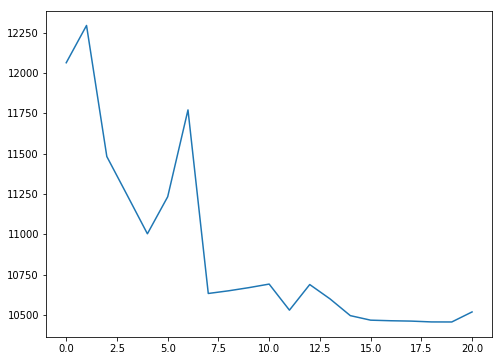

In [8]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
col = 'val_loss' if 'val_loss' in df else 'loss'
df[col][-25:].plot(figsize=(8, 6))

In [9]:
debug = False

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                # =======================================================
                #x_out = model.predict(X_train, num_samples)
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    offset = k * mixture_components
                    x_ms = x_out[n, i, j, offset:offset + mixture_components]
                    
                    offset = mixture_components * img_chns + k * mixture_components
                    x_invs = x_out[n, i, j, offset:offset + mixture_components]
                    
                    offset = 2 * mixture_components * img_chns + k * mixture_components
                    weights = softmax(x_out[n, i, j, offset:offset + mixture_components])
                    
                    pvals = compute_mixture(x_ms, x_invs, weights, mixture_components)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = (pixel_val - 127.5) / 127.5
                    if 0 <= i <= 3 and 0 <= j <= 3 and n == 0 and debug:
                        print("====", i, j, k)
                        print("X_train[0/1", i, j, k, "] = ", X_train[0, i, j, k], ', ', X_train[1, i, j, k], 
                              " (%s, %s)" % (X_train[0, i, j, k] * 127.5 + 127.5, X_train[1, i, j, k] * 127.5 + 127.5))
                        print(" m: ", x_ms, "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" E[m]: ", (x_ms * weights).sum(), "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" invs: ", x_invs)
                        print(" weights: ", weights, " (", x_out[n, i, j, offset:offset + mixture_components] ,")")
                        s = pd.Series(pvals)
                        print(" pvals: ", s[s>1e-2])
                        print(" pixel_val: ", pixel_val)
                        samples = pd.Series(np.random.choice(len(pvals), 1000, p=pvals / pvals.sum()))
                        samples.hist(bins=128, alpha=0.5, label='generated')
        print("row", i)
        
                
    return (x_sample * 127.5 + 127.5)


In [10]:
start = time.time()

n = 1 if debug else batch_size
num_samples = min(n, batch_size)
rows = int(n // np.ceil(np.sqrt(num_samples)))
cols = int(n // np.ceil(np.sqrt(num_samples)))

figure = np.zeros((img_rows * rows, img_cols * cols, img_chns))
print(figure.shape)
samples = gen_image(model, num_samples=num_samples)
for i in range(rows):
    for j in range(cols):
        img = samples[i * rows + j] / 255.
        d_x = (i * img_rows)
        d_y = (j * img_cols)
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

(128, 128, 3)
row 0
row 1
row 2
row 3
row 4
row 5
row 6
row 7
row 8
row 9
row 10
row 11
row 12
row 13
row 14
row 15
row 16
row 17
row 18
row 19
row 20
row 21
row 22
row 23
row 24
row 25
row 26
row 27
row 28
row 29
row 30
row 31
Elapsed:  2207.7177872657776


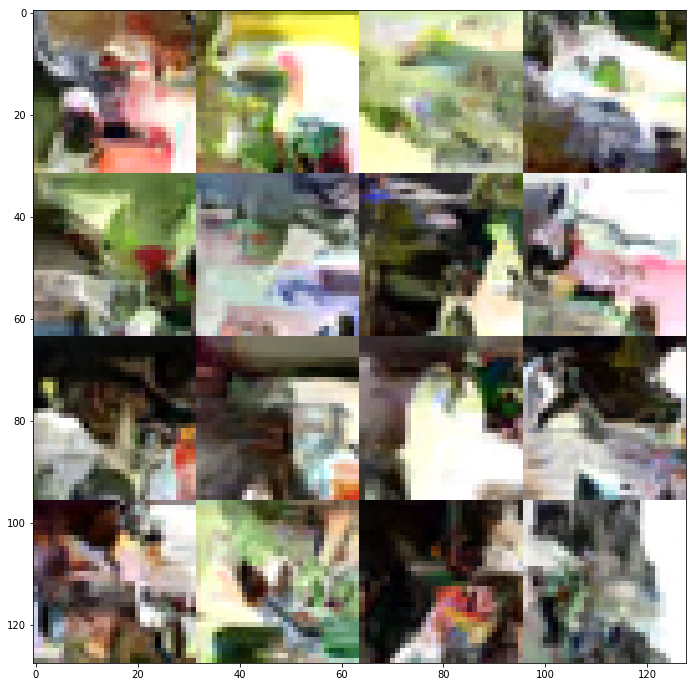

In [11]:
plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()